# Setup

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist


# Part I: Implementing PCA

In [2]:
def compute_covariance_matrix(X):
    n_samples = X.shape[0]

    # Calculate the mean along the samples axis
    mean = np.mean(X, axis=0)

    # Subtract the mean from the data
    centered_data = X - mean

    # Calculate the covariance matrix
    # Dividing by n − 1 instead of n adjusts for the loss of degree of freedom when estinating the sample mean
    cov_matrix = np.dot(centered_data.T, centered_data) / (n_samples - 1)

    return cov_matrix

In [3]:
# mean: mean of the columns of X
# vectors: contains the principal components of X
# weights: corresponding eigenvalues of the vectors

def pca(X):
    # Compute mean of each feature
    mean = np.mean(X, axis=0)

    # Center the data
    X_centered = X - mean

    # After centering the data, covariance matrix is just the matrix multiplication of features over num samples
    n_samples = X.shape[0]
    cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)

    # Perform SVD on the covariance matrix
    U, S, Vt = np.linalg.svd(cov_matrix)

    # Eigenvectors are the columns of Vt, and eigenvalues are the squares of the singular values
    eigenvectors = Vt.T
    eigenvalues = S**2 / (n_samples - 1)

    # Sort the eigenvalues in descending order and rearrange the eigenvectors to match
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    return mean, eigenvectors, eigenvalues

# Part II: Using PCA before Classification

## Results:

In [4]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

X = np.concatenate([x_train, x_test])
y = np.concatenate([y_train, y_test])

# Flatten the data
X = X.reshape(-1, 28 * 28)

# Select random 1000 images from the training set
np.random.seed(42)
random_indices = np.random.choice(X.shape[0], size=1000, replace=False)
X_subset = X[random_indices]
y_subset = y[random_indices]

11490434/11490434 [==============================] - 0s 0us/step


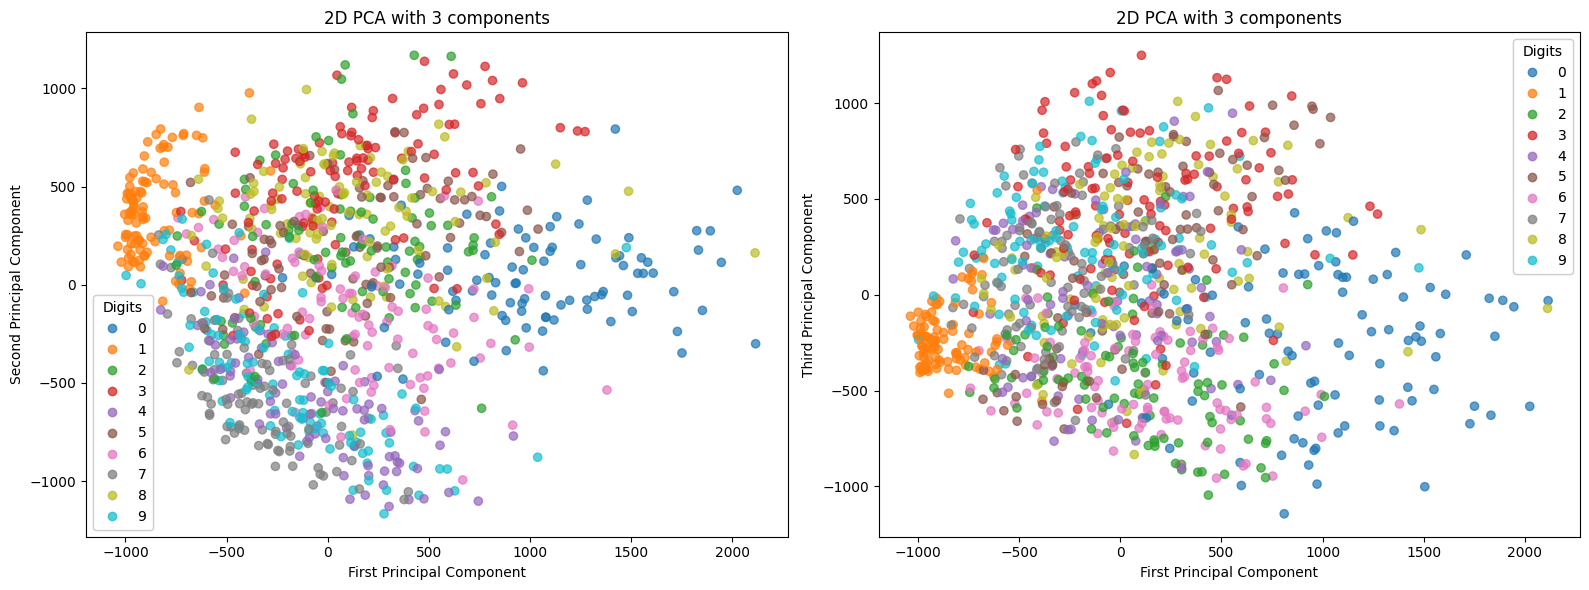

In [5]:
# Get the eigenvectors and eigenvalues
mean, vectors, weights = pca(X_subset)

n_components = 3

# Apply the transformation (Do we need to apply this each time!)
W = vectors[:, :n_components]
X_subset_pca = np.dot(X_subset - mean, W)

# Create subplots for the two plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot first vs second principal component
scatter1 = axes[0].scatter(X_subset_pca[:, 0], X_subset_pca[:, 1], c=y_subset, cmap='tab10', alpha=0.7)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title(f'2D PCA with {n_components} components')
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Digits")
axes[0].add_artist(legend1)

scatter2 = axes[1].scatter(X_subset_pca[:, 0], X_subset_pca[:, 2], c=y_subset, cmap='tab10', alpha=0.7)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Third Principal Component')
axes[1].set_title(f'2D PCA with {n_components} components')
legend2 = axes[1].legend(*scatter2.legend_elements(), title="Digits")
axes[1].add_artist(legend2)

plt.tight_layout()
plt.show()

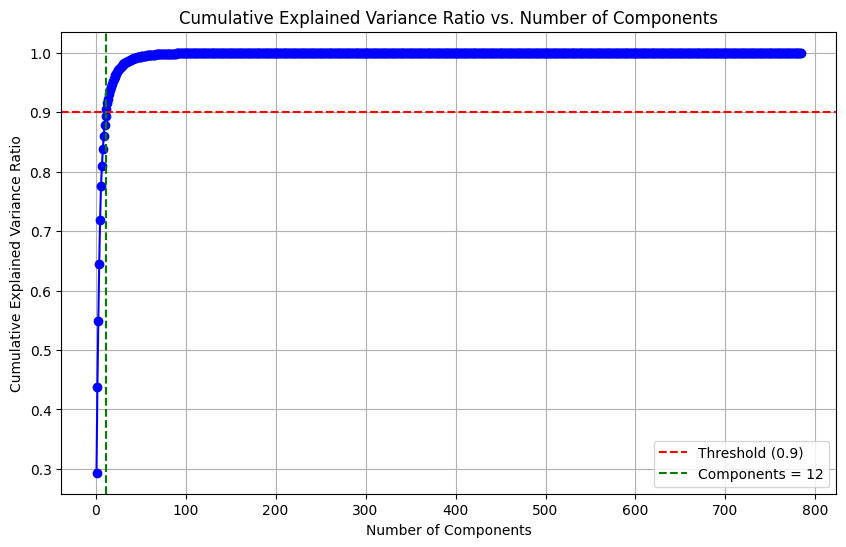

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_explained_variance_ratio(explained_variance_ratio, threshold=0.95):
    cumulative_var_ratio = np.cumsum(explained_variance_ratio)
    n_components = len(explained_variance_ratio)
    threshold_index = np.argmax(cumulative_var_ratio >= threshold) + 1

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_components + 1), cumulative_var_ratio, marker='o', linestyle='-', color='b')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.axvline(x=threshold_index, color='g', linestyle='--', label=f'Components = {threshold_index}')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
    plt.legend()
    plt.grid(True)
    plt.show()

explained_variance_ratio = np.array([0.5, 0.3, 0.1, 0.05, 0.03, 0.02])
explained_variance_ratio = weights / np.sum(weights)
plot_explained_variance_ratio(explained_variance_ratio, threshold=0.9)

The top 12 eigenvectors, explaining 90% of the proportion of variance (PoV), indicate the efficacy of reducing features from 784 to 12 through PCA.

In [7]:
n_estimators = 100
random_state = 42

# First check the accuracy without dimention reduction
rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
scores = cross_val_score(rf_classifier, X_subset, y_subset, cv=5)
print(f"Mean accuracy without PCA: {np.mean(scores):.3f}")

# mnist dataset consist of 28x28 images
img_size = 28
n_components = int(np.log2(img_size**2) + 1)

# Perform PCA with at least four different values for the number of components chosen
n_components_list = [2**i for i in range(1, n_components)]

for n_components in n_components_list:
    # Apply the transformation
    W = vectors[:, :n_components]
    X_subset_pca = np.dot(X_subset - mean, W)

    # Train a Random Forest classifier and evaluate classification results using cross-validation
    rf_classifier = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)
    scores = cross_val_score(rf_classifier, X_subset_pca, y_subset, cv=5)
    print(f"Mean accuracy with {n_components} components: {np.mean(scores):.3f}")

Mean accuracy without PCA: 0.878
Mean accuracy with 2 components: 0.393
Mean accuracy with 4 components: 0.580
Mean accuracy with 8 components: 0.803
Mean accuracy with 16 components: 0.844
Mean accuracy with 32 components: 0.864
Mean accuracy with 64 components: 0.850
Mean accuracy with 128 components: 0.838
Mean accuracy with 256 components: 0.799
Mean accuracy with 512 components: 0.718


## Comparing results with scikit-learn PCA Implementation

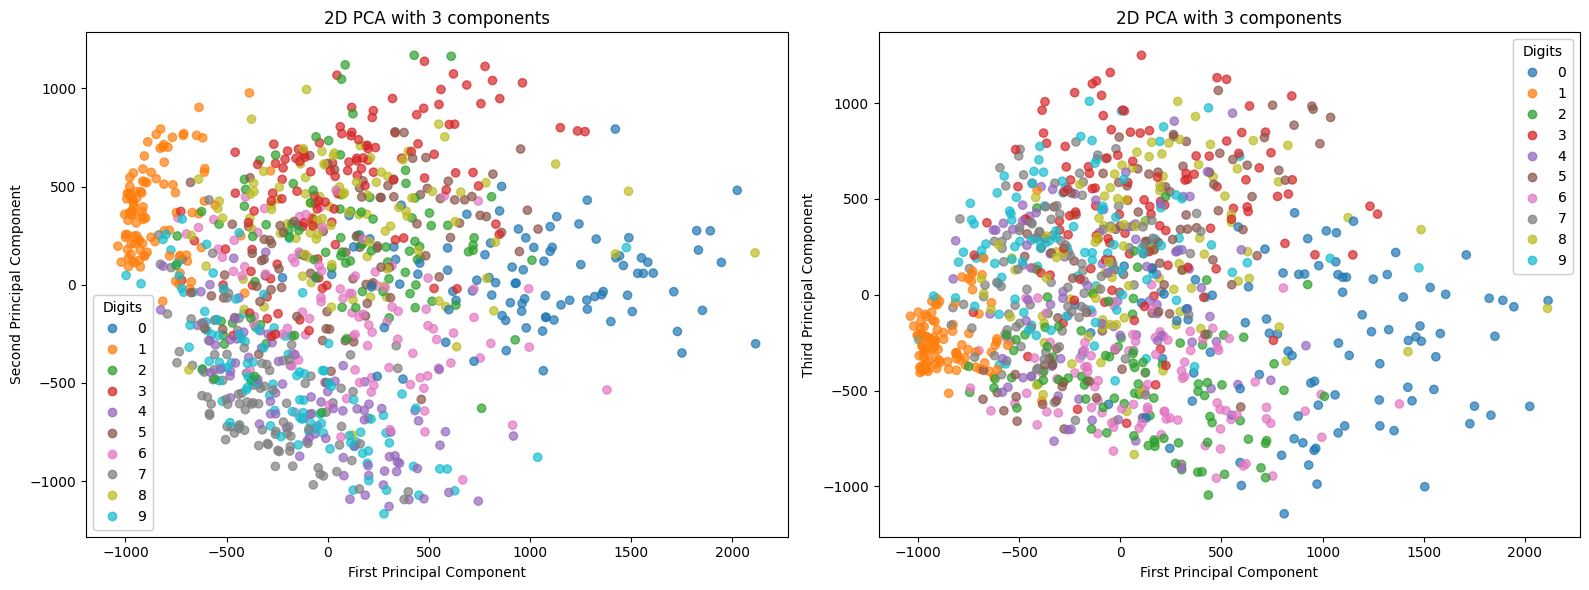

In [8]:
from sklearn.decomposition import PCA

n_components = 3

pca = PCA(n_components=n_components)
X_subset_pca = pca.fit_transform(X_subset)

# Create subplots for the two plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot first vs second principal component
scatter1 = axes[0].scatter(X_subset_pca[:, 0], X_subset_pca[:, 1], c=y_subset, cmap='tab10', alpha=0.7)
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].set_title(f'2D PCA with {n_components} components')
legend1 = axes[0].legend(*scatter1.legend_elements(), title="Digits")
axes[0].add_artist(legend1)

scatter2 = axes[1].scatter(X_subset_pca[:, 0], X_subset_pca[:, 2], c=y_subset, cmap='tab10', alpha=0.7)
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Third Principal Component')
axes[1].set_title(f'2D PCA with {n_components} components')
legend2 = axes[1].legend(*scatter2.legend_elements(), title="Digits")
axes[1].add_artist(legend2)

plt.tight_layout()
plt.show()

In [9]:
# Perform PCA with at least four different values for the number of components chosen
n_components_list = [8, 16, 32, 64, 128, 256]

for n_components in n_components_list:
    pca = PCA(n_components=n_components)
    X_subset_pca = pca.fit_transform(X_subset)

    # Train a Random Forest classifier and evaluate classification results using cross-validation
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    scores = cross_val_score(rf_classifier, X_subset_pca, y_subset, cv=5)
    print(f"Mean accuracy with {n_components} components: {np.mean(scores):.3f}")

Mean accuracy with 8 components: 0.808
Mean accuracy with 16 components: 0.856
Mean accuracy with 32 components: 0.866
Mean accuracy with 64 components: 0.847
Mean accuracy with 128 components: 0.829
Mean accuracy with 256 components: 0.796


## Conclusions:

In summary, the application of PCA in reducing the dimensionality from 784 to 12 while preserving 90% of the variance effectively streamlines the dataset, making it more manageable and useful for various downstream tasks such as clustering, visualization, and predictive modeling in machine learning. This efficiency is particularly valuable in fields where the dimensionality of data is inherently high and difficult to work with directly.